In [2]:
import json
import os
from pickle import TRUE
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange

import argparse

from env import Box, get_last_states
from model import CirclePF, CirclePB, NeuralNet
from sampling import (
    sample_trajectories,
    evaluate_backward_logprobs,
    evaluate_state_flows,
    evaluate_forward_logprobs,
)
from replay_memory import TrajectoryReplayMemory

from utils import (
    fit_kde,
    plot_reward,
    sample_from_reward,
    plot_samples,
    estimate_jsd,
    plot_trajectories,
)

import config


parser = argparse.ArgumentParser()
parser.add_argument("--device", type=str, default=config.DEVICE)
parser.add_argument("--dim", type=int, default=config.DIM)
parser.add_argument("--delta", type=float, default=config.DELTA)
parser.add_argument(
    "--n_components",
    type=int,
    default=config.N_COMPONENTS,
    help="Number of components in Mixture Of Betas",
)

parser.add_argument("--reward_debug", action="store_true", default=config.REWARD_DEBUG)
parser.add_argument(
    "--reward_type",
    type=str,
    choices=["baseline", "ring", "angular_ring", "multi_ring", "curve", "gaussian_mixture", "corner_squares", "two_corners", "edge_boxes", "edge_boxes_corner_squares"],
    default=config.REWARD_TYPE,
    help="Type of reward function to use. To modify reward-specific parameters (radius, sigma, etc.), edit rewards.py"
)
parser.add_argument("--R0", type=float, default=config.R0, help="Baseline reward value")
parser.add_argument("--R1", type=float, default=config.R1, help="Medium reward value (e.g., outer square)")
parser.add_argument("--R2", type=float, default=config.R2, help="High reward value (e.g., inner square)")
parser.add_argument(
    "--n_components_s0",
    type=int,
    default=config.N_COMPONENTS_S0,
    help="Number of components in Mixture Of Betas",
)
parser.add_argument(
    "--beta_min",
    type=float,
    default=config.BETA_MIN,
    help="Minimum value for the concentration parameters of the Beta distribution",
)
parser.add_argument(
    "--beta_max",
    type=float,
    default=config.BETA_MAX,
    help="Maximum value for the concentration parameters of the Beta distribution",
)
parser.add_argument(
    "--PB",
    type=str,
    choices=["learnable", "tied", "uniform"],
    default=config.PB,
)
parser.add_argument("--loss", type=str, choices=["tb", "db"], default=config.LOSS)
parser.add_argument("--gamma_scheduler", type=float, default=config.GAMMA_SCHEDULER)
parser.add_argument("--scheduler_milestone", type=int, default=config.SCHEDULER_MILESTONE)
parser.add_argument("--seed", type=int, default=config.SEED)
parser.add_argument("--lr", type=float, default=config.LR)
parser.add_argument("--lr_Z", type=float, default=config.LR_Z)
parser.add_argument("--lr_F", type=float, default=config.LR_F)
parser.add_argument("--alpha", type=float, default=config.ALPHA)
parser.add_argument("--tie_F", action="store_true", default=config.TIE_F)
parser.add_argument("--BS", type=int, default=config.BS)
parser.add_argument("--n_iterations", type=int, default=config.N_ITERATIONS)
parser.add_argument("--n_evaluation_interval", type=int, default=config.N_EVALUATION_INTERVAL)
parser.add_argument("--n_logging_interval", type=int, default=config.N_LOGGING_INTERVAL)
parser.add_argument("--hidden_dim", type=int, default=config.HIDDEN_DIM)
parser.add_argument("--n_hidden", type=int, default=config.N_HIDDEN)
parser.add_argument("--n_evaluation_trajectories", type=int, default=config.N_EVALUATION_TRAJECTORIES)
parser.add_argument("--no_plot", action="store_true", default=config.NO_PLOT)
parser.add_argument("--no_wandb", action="store_true", default=config.NO_WANDB)
parser.add_argument("--wandb_project", type=str, default=config.WANDB_PROJECT)
parser.add_argument("--uniform_ratio", type=float, default=config.UNIFORM_RATIO)
parser.add_argument("--replay_size", type=int, default=config.REPLAY_SIZE)
args = parser.parse_args([])



device = args.device
dim = args.dim
delta = args.delta
seed = args.seed
lr = args.lr
lr_Z = args.lr_Z
lr_F = args.lr_F
n_iterations = args.n_iterations
BS = args.BS
n_components = args.n_components
n_components_s0 = args.n_components_s0

if seed == 0:
    seed = np.random.randint(int(1e6))


torch.manual_seed(seed)
np.random.seed(seed)

print(f"Using device: {device}")


Using device: cuda:3


In [3]:

env = Box(
    dim=dim,
    delta=delta,
    device_str=device,
    reward_type=args.reward_type,
    reward_debug=args.reward_debug,
    R0=args.R0,
    R1=args.R1,
    R2=args.R2,
)

# Get the true KDE
samples = sample_from_reward(env, n_samples=10000)
true_kde, fig1 = fit_kde(samples, plot=True)



model = CirclePF(
    hidden_dim=args.hidden_dim,
    n_hidden=args.n_hidden,
    n_components=n_components,
    n_components_s0=n_components_s0,
    beta_min=args.beta_min,
    beta_max=args.beta_max,
    uniform = False,
).to(device)

bw_model = CirclePB(
    hidden_dim=args.hidden_dim,
    n_hidden=args.n_hidden,
    torso=model.torso if args.PB == "tied" else None,
    uniform=args.PB == "uniform",
    n_components=n_components,
    beta_min=args.beta_min,
    beta_max=args.beta_max,
).to(device)

if args.loss == "db":
    flow_model = NeuralNet(
        hidden_dim=args.hidden_dim,
        n_hidden=args.n_hidden,
        torso=None if not args.tie_F else model.torso,
        output_dim=1,
    ).to(device)

logZ = torch.zeros(1, requires_grad=True, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
if args.PB != "uniform":
    optimizer.add_param_group(
        {
            "params": bw_model.output_layer.parameters()
            if args.PB == "tied"
            else bw_model.parameters(),
            "lr": lr,
        }
    )
optimizer.add_param_group({"params": [logZ], "lr": lr_Z})

if args.loss == "db":
    optimizer.add_param_group(
        {
            "params": flow_model.output_layer.parameters()
            if args.tie_F
            else flow_model.parameters(),
            "lr": lr_F,
        }
    )
    print("using flow model")

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[i * args.scheduler_milestone for i in range(1, 10)],
    gamma=args.gamma_scheduler,
)

jsd = float("inf")


In [10]:
memory = TrajectoryReplayMemory(3, seed, device)

for i in trange(10):
    optimizer.zero_grad()
    if np.random.rand() < args.uniform_ratio: 
        model.uniform = True
        trajectories, _, sampless = sample_trajectories(
            env,
            model,
            1,
        )
    else:
        model.uniform = False
        trajectories, _, sampless = sample_trajectories(
            env,
            model,
            1,
        )
    
    print(f"\n=== Iteration {i} ===")
    print(f"Sampled trajectories shape: {trajectories.shape}")
    print(f"Sampled sampless shape: {sampless.shape}")
    print(f"Memory size before push: {len(memory)}")
    
    memory.push_batch(trajectories, sampless)
    
    print(f"Memory size after push: {len(memory)}")
    
    retrieved_trajectories, retrieved_sampless = memory.sample(1)
    
    print(f"Retrieved trajectories shape: {retrieved_trajectories.shape}")
    print(f"Retrieved sampless shape: {retrieved_sampless.shape}")
    print(f"Are retrieved same as sampled? {torch.allclose(trajectories, retrieved_trajectories) if trajectories.shape == retrieved_trajectories.shape else 'Different shapes'}")

    while torch.all(retrieved_trajectories[:,-2,:] == env.sink_state):
        retrieved_trajectories = retrieved_trajectories[:,:-1,:]
        retrieved_sampless = retrieved_sampless[:,:-1,:]
    print(retrieved_trajectories, '\n', retrieved_sampless)
    
    print(f"Final trajectories shape after trimming: {retrieved_trajectories.shape}")
    print(f"Final sampless shape after trimming: {retrieved_sampless.shape}")
    print(memory.trajectories, '\n', memory.samples)
    logprobs, all_logprobs = evaluate_forward_logprobs(env, model, retrieved_trajectories, retrieved_sampless)

    # Store trajectories in replay buffer
    last_states = get_last_states(env, retrieved_trajectories)
    logrewards = env.reward(last_states).log()
    bw_logprobs, all_bw_logprobs = evaluate_backward_logprobs(
        env, bw_model, retrieved_trajectories
    )

    # TB (Trajectory Balance) loss
    if args.loss == "tb":
        loss = torch.mean((logZ + logprobs - bw_logprobs - logrewards) ** 2)

    elif args.loss == "db":
        log_state_flows = evaluate_state_flows(env, flow_model, retrieved_trajectories, logZ)  # type: ignore
        db_preds = all_logprobs + log_state_flows
        db_targets = all_bw_logprobs + log_state_flows[:, 1:]
        if args.alpha == 1.0:
            db_targets = torch.cat(
                [
                    db_targets,
                    torch.full(
                        (db_targets.shape[0], 1),
                        -float("inf"),
                        device=db_targets.device,
                    ),
                ],
                dim=1,
            )
            infinity_mask = db_targets == -float("inf")
            _, indices_of_first_inf = torch.max(infinity_mask, dim=1)
            db_targets = db_targets.scatter(
                1, indices_of_first_inf.unsqueeze(1), logrewards.unsqueeze(1)
            )
            flat_db_preds = db_preds[db_preds != -float("inf")]
            flat_db_targets = db_targets[db_targets != -float("inf")]
            loss = torch.mean((flat_db_preds - flat_db_targets) ** 2)
    
    print(f"Loss: {loss.item()}")
    
    if torch.isinf(loss):
        raise ValueError("Infinite loss")
    loss.backward()
    # clip the gradients for bw_model
    for p in bw_model.parameters():
        if p.grad is not None:
            p.grad.data.clamp_(-10, 10).nan_to_num_(0.0)
    for p in model.parameters():
        if p.grad is not None:
            p.grad.data.clamp_(-10, 10).nan_to_num_(0.0)
    optimizer.step()
    scheduler.step()

    if any(
        [
            torch.isnan(list(model.parameters())[i]).any()
            for i in range(len(list(model.parameters())))
        ]
    ):
        raise ValueError("NaN in model parameters")


 20%|██        | 2/10 [00:00<00:00,  8.68it/s]


=== Iteration 0 ===
Sampled trajectories shape: torch.Size([1, 7, 2])
Sampled sampless shape: torch.Size([1, 6, 2])
Memory size before push: 0
Memory size after push: 1
Retrieved trajectories shape: torch.Size([1, 7, 2])
Retrieved sampless shape: torch.Size([1, 6, 2])
Are retrieved same as sampled? True
tensor([[[0.0000, 0.0000],
         [0.0152, 0.0039],
         [0.2643, 0.0258],
         [0.5058, 0.0905],
         [0.6992, 0.2489],
         [0.9074, 0.3873],
         [  -inf,   -inf]]], device='cuda:3') 
 tensor([[[0.0630, 0.1593],
         [0.0559, 0.0000],
         [0.1666, 0.0000],
         [0.4369, 0.0000],
         [0.3734, 0.0000],
         [  -inf, 0.0000]]], device='cuda:3')
Final trajectories shape after trimming: torch.Size([1, 7, 2])
Final sampless shape after trimming: torch.Size([1, 6, 2])
tensor([[[0.0000, 0.0000],
         [0.0152, 0.0039],
         [0.2643, 0.0258],
         [0.5058, 0.0905],
         [0.6992, 0.2489],
         [0.9074, 0.3873],
         [  -inf,  

 30%|███       | 3/10 [00:00<00:00,  9.03it/s]


=== Iteration 2 ===
Sampled trajectories shape: torch.Size([1, 8, 2])
Sampled sampless shape: torch.Size([1, 7, 2])
Memory size before push: 2
Memory size after push: 3
Retrieved trajectories shape: torch.Size([1, 8, 2])
Retrieved sampless shape: torch.Size([1, 7, 2])
Are retrieved same as sampled? False
tensor([[[0.0000, 0.0000],
         [0.0152, 0.0039],
         [0.2643, 0.0258],
         [0.5058, 0.0905],
         [0.6992, 0.2489],
         [0.9074, 0.3873],
         [  -inf,   -inf]]], device='cuda:3') 
 tensor([[[0.0630, 0.1593],
         [0.0559, 0.0000],
         [0.1666, 0.0000],
         [0.4369, 0.0000],
         [0.3734, 0.0000],
         [  -inf, 0.0000]]], device='cuda:3')
Final trajectories shape after trimming: torch.Size([1, 7, 2])
Final sampless shape after trimming: torch.Size([1, 6, 2])
tensor([[[0.0000, 0.0000],
         [0.0152, 0.0039],
         [0.2643, 0.0258],
         [0.5058, 0.0905],
         [0.6992, 0.2489],
         [0.9074, 0.3873],
         [  -inf, 

 50%|█████     | 5/10 [00:00<00:00,  9.73it/s]

tensor([[[0.9185, 0.2667],
         [0.2633, 0.0000],
         [0.2096, 0.0000],
         [0.3574, 0.0000],
         [  -inf, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.4523, 0.0312],
         [0.8885, 0.0000],
         [0.3217, 0.0000],
         [0.3568, 0.0000],
         [0.1767, 0.0000],
         [  -inf, 0.0000],
         [  -inf,   -inf]],

        [[0.2787, 0.4397],
         [0.7454, 0.0000],
         [0.7235, 0.0000],
         [0.2320, 0.0000],
         [0.2541, 0.0000],
         [0.2308, 0.0000],
         [  -inf, 0.0000]]], device='cuda:3')
Loss: 8.135189056396484

=== Iteration 5 ===
Sampled trajectories shape: torch.Size([1, 7, 2])
Sampled sampless shape: torch.Size([1, 6, 2])
Memory size before push: 3
Memory size after push: 3
Retrieved trajectories shape: torch.Size([1, 8, 2])
Retrieved sampless shape: torch.Size([1, 7, 2])
Are retrieved same as sampled? Different shapes
tensor([[[0.0000, 0.0000],
         [0.1130, 0.0055],
         [0.15

 90%|█████████ | 9/10 [00:00<00:00, 10.63it/s]

Loss: 76.52078247070312

=== Iteration 7 ===
Sampled trajectories shape: torch.Size([1, 7, 2])
Sampled sampless shape: torch.Size([1, 6, 2])
Memory size before push: 3
Memory size after push: 3
Retrieved trajectories shape: torch.Size([1, 8, 2])
Retrieved sampless shape: torch.Size([1, 7, 2])
Are retrieved same as sampled? Different shapes
tensor([[[0.0000, 0.0000],
         [0.0443, 0.0133],
         [0.2926, 0.0422],
         [0.3816, 0.2758],
         [0.5856, 0.4202],
         [0.7795, 0.5780],
         [  -inf,   -inf]]], device='cuda:3') 
 tensor([[[0.1849, 0.1855],
         [0.0738, 0.0000],
         [0.7684, 0.0000],
         [0.3921, 0.0000],
         [0.4349, 0.0000],
         [  -inf, 0.0000]]], device='cuda:3')
Final trajectories shape after trimming: torch.Size([1, 7, 2])
Final sampless shape after trimming: torch.Size([1, 6, 2])
tensor([[[0.0000, 0.0000],
         [0.1991, 0.1186],
         [0.4486, 0.1339],
         [0.4635, 0.3834],
         [0.6579, 0.5406],
         [

100%|██████████| 10/10 [00:00<00:00, 10.22it/s]


=== Iteration 9 ===
Sampled trajectories shape: torch.Size([1, 6, 2])
Sampled sampless shape: torch.Size([1, 5, 2])
Memory size before push: 3
Memory size after push: 3
Retrieved trajectories shape: torch.Size([1, 8, 2])
Retrieved sampless shape: torch.Size([1, 7, 2])
Are retrieved same as sampled? Different shapes
tensor([[[0.0000, 0.0000],
         [0.1163, 0.0391],
         [0.3145, 0.1915],
         [0.4183, 0.4189],
         [0.6553, 0.4984],
         [0.7522, 0.7289],
         [  -inf,   -inf]]], device='cuda:3') 
 tensor([[[0.4908, 0.2063],
         [0.4173, 0.0000],
         [0.7274, 0.0000],
         [0.2061, 0.0000],
         [0.7467, 0.0000],
         [  -inf, 0.0000]]], device='cuda:3')
Final trajectories shape after trimming: torch.Size([1, 7, 2])
Final sampless shape after trimming: torch.Size([1, 6, 2])
tensor([[[0.0000, 0.0000],
         [0.0904, 0.0881],
         [0.3225, 0.1810],
         [0.5715, 0.2034],
         [0.7901, 0.3247],
         [  -inf,   -inf],
       

In [ ]:


def reward_corner_small_squares(final_states, R0, R1, R2, **kwargs):
    """
    Corner squares reward: high reward in corners with nested structure.

    Structure (for 2D):
    - 3 corners (excluding bottom-left) each have an outer square of size 0.25 × 0.25
    - Inside each outer square (centered), there's an inner square of size 0.125 × 0.125
    - Outer square: reward R1 (e.g., 10)
    - Inner square (centered in outer square): reward R2 (e.g., 100)
    - Rest: reward 1e-9 (baseline)

    Corner positions:
    - Bottom-right: (1, 0)
    - Top-left: (0, 1)
    - Top-right: (1, 1)
    """
    device = final_states.device
    batch_size = final_states.shape[0]
    dim = final_states.shape[-1]

    if dim != 2:
        raise NotImplementedError("corner_squares only implemented for dim=2")

    # Fixed sizes for corner reward regions
    outer_size = 0.25
    inner_size = 0.125  # outer_size / 2

    # Initialize with baseline reward (1e-9 instead of 0)
    reward = torch.full((batch_size,), R0, device=device)

    x = final_states[:, 0]  # x coordinate
    y = final_states[:, 1]  # y coordinate

    # Define corners and check each one (excluding bottom-left where s0 is)
    corners = [
        (1.0, 0.0),  # bottom-right
        (0.0, 1.0),  # top-left
        (1.0, 1.0),  # top-right
    ]

    for cx, cy in corners:
        # Distance from corner
        if cx == 0.0:
            dx = x
        else:  # cx == 1.0
            dx = 1.0 - x

        if cy == 0.0:
            dy = y
        else:  # cy == 1.0
            dy = 1.0 - y

        # Check if in outer square (size 0.25 × 0.25 from corner)
        in_outer = (dx <= outer_size) & (dy <= outer_size)

        # For inner square, check if centered within outer square
        # Distance from center of outer square
        dx_from_center = torch.abs(dx - outer_size)  # distance from center of outer square
        dy_from_center = torch.abs(dy - outer_size)

        # Inner square is centered in the outer square
        in_inner = (dx_from_center <= inner_size) & (dy_from_center <= inner_size) & in_outer

        # Assign rewards: inner overrides outer
        reward[in_outer] = R1
        reward[in_inner] = R2

    return reward

def Z_corner_small_squares(dim, R0, R1, R2, **kwargs):
    """Partition function for corner_squares reward with fixed corner size of 0.25."""
    if dim != 2:
        raise NotImplementedError("corner_squares Z only implemented for dim=2")

    # Fixed corner size
    corner_size = 0.25
    inner_size = 0.125

    # Area of each outer square
    outer_square_area = corner_size * corner_size

    # Area of each inner square
    inner_square_area = inner_size * inner_size

    # Area with R1 reward (outer square minus inner square) × 3 corners (excluding bottom-left)
    area_R1 = 3 * (outer_square_area - inner_square_area)

    # Area with R2 reward (inner square) × 3 corners
    area_R2 = 3 * inner_square_area



    # Rest of the space (unit square minus 3 corner squares)
    area_R0 = 1.0 - 3 * outer_square_area - (1.0 - corner_size)**2


    # Use 1e-9 as baseline instead of R0
    Z = R0 * area_R0 + R1 * area_R1 + R2 * area_R2

    return Z


In [35]:



class Box:
    """D-dimensional box with lower bound 0 and upper bound 1. A maximum step size 0<delta<1 defines
    the maximum unidimensional step size in each dimension.
    """

    def __init__(
        self,
        dim=2,
        delta=0.1,
        R0=0.1,
        R1=1.0,
        R2=2.0,
        reward_type="baseline",
        reward_debug=False,
        device_str="cpu",
        verify_actions=False,
    ):
        # Set verify_actions to False to disable action verification for faster step execution.
        self.dim = dim
        self.delta = delta
        self.device_str = device_str
        self.device = torch.device(device_str)
        self.terminal_action = torch.full((dim,), -float("inf"), device=self.device)
        self.sink_state = torch.full((dim,), -float("inf"), device=self.device)
        self.verify_actions = verify_actions

        # Reward parameters
        self.R0 = R0
        self.R1 = R1
        self.R2 = R2
        self.reward_type = reward_type
        self.reward_debug = reward_debug

        # Basic parameters passed to reward functions
        # Reward-specific parameters (radius, sigma, etc.) are defined in rewards.py
        self.reward_params = {
            'R0': R0,
            'R1': R1,
            'R2': R2,
            'delta': delta,
        }
        self.reward_fn = reward_corner_squares
        self.Z_fn = Z_corner_squares
    def is_terminal_action_mask(self, actions):
        """Return a mask of terminal actions."""
        return torch.all(actions == self.terminal_action, dim=-1)

    def step(self, states, actions) :
        """Take a step in the environment. The states can include the sink state [-inf, ..., -inf].
        In which case, the corresponding actions are ignored."""
        # First, select the states that are not the sink state.
        non_sink_mask = ~torch.all(states == self.sink_state, dim=-1)
        non_sink_states = states[non_sink_mask]
        non_sink_actions = actions[non_sink_mask]
        # Then, select states and actions not corresponding to terminal actions, for the non sink states and actions.
        non_terminal_mask = ~self.is_terminal_action_mask(non_sink_actions)
        non_terminal_states = non_sink_states[non_terminal_mask]
        non_terminal_actions = non_sink_actions[non_terminal_mask]
        # Then, take a step and store that in a new tensor.
        new_states = torch.full_like(states, -float("inf"))
        non_sink_new_states = new_states[non_sink_mask]
        non_sink_new_states[non_terminal_mask] = (
            non_terminal_states + non_terminal_actions
        )
        new_states[non_sink_mask] = non_sink_new_states
        # Finally, return the new states.
        return new_states

    def reward(self, final_states):
        """Compute reward for final states using the configured reward function."""
        return self.reward_fn(final_states, **self.reward_params)

    @property
    def Z(self):
        """Compute partition function using the configured Z function."""
        return self.Z_fn(self.dim, **self.reward_params)


def get_last_states(env: Box, trajectories):
    """Get last states from trajectories.
    Args:
        trajectories: A tensor of trajectories
    Returns:
        last_states: A tensor of last states
    """
    non_sink = ~torch.all(trajectories == env.sink_state, dim=-1)

    mask = torch.zeros_like(non_sink).bool()
    mask.scatter_(1, non_sink.cumsum(dim=-1).argmax(dim=-1, keepdim=True), True)

    return trajectories[mask]
        


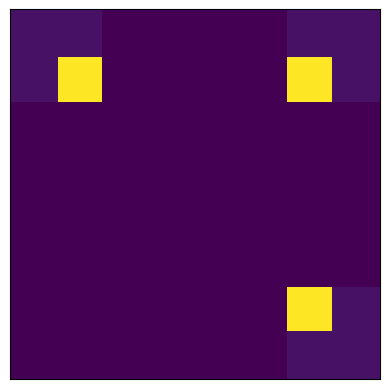

In [37]:

env = Box(
    dim=dim,
    delta=delta,
    device_str=device,
    reward_type=args.reward_type,
    reward_debug=args.reward_debug,
    R0=args.R0,
    R1=args.R1,
    R2=args.R2,
)


def get_test_states(n=100, maxi=1.0):
    x = np.linspace(0.001, maxi, n)
    y = np.linspace(0.001, maxi, n)
    xx, yy = np.meshgrid(x, y)
    test_states = np.stack([xx, yy], axis=-1).reshape(-1, 2)
    return test_states, n

def plot_reward(env):
    test_states, n = get_test_states()
    test_states = torch.FloatTensor(test_states)

    # Check if states are terminal (at least one dimension is within delta of boundary)
    should_terminate = torch.any(test_states >= 1 - env.delta, dim=-1)

    # Calculate rewards
    reward = torch.full((test_states.shape[0],), 1e-9)
    reward[should_terminate] = env.reward(test_states[should_terminate])

    reward = reward.reshape(n, n)
    fig = plt.imshow(reward, origin="lower", extent=[0, 1, 0, 1])
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close("all")

    return fig

fig2 = plot_reward(env)
